In [1]:
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F
from torch.autograd import grad
import lightning as L
import numpy as np
import matplotlib.pyplot as plt

In [22]:
class ODE_Learner(L.LightningModule):
    def __init__(self, init_condition, gamma):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1),
        )

        self.init_condition = init_condition
        self.gamma = gamma

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def g(self, x, g_t):
        return self.gamma * g_t

    def g_trial(self, x):
        return self.init_condition + x * self.forward(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x.requires_grad = True

        g_t = self.init_condition + x * self.forward(x)
        sol = self.gamma * g_t
        dgt_dx = grad(
            retain_graph=True, outputs=g_t, inputs=x, grad_outputs=torch.ones_like(x)
        )[0]

        loss = nn.MSELoss()(dgt_dx, sol)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

In [20]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n):

        self.n = n
        self.x = torch.linspace(init, end, self.n)
        self.y = 10 * np.exp(2 * self.x)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):

        x = self.x[idx, np.newaxis]
        y = self.y[idx, np.newaxis]

        return torch.Tensor(x), torch.Tensor(y)

In [21]:
train = Dataset(0, 2, 1000)

trainer = L.Trainer(logger=False, max_epochs=1000)
learner = ODE_Learner(10, 2)
trainer.fit(learner, data.DataLoader(train, batch_size=1000))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory c:\Users\zheyu\OneDrive\Documents\GitHub\Senior-Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 901   
-------------------------------------
901       Trainable params
0         Non-trainable params
901       Total params
0.004     Total estimated model params size (MB)
c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in t

Training: |          | 0/? [00:00<?, ?it/s]

tensor([[10.0000],
        [10.0004],
        [10.0007],
        [10.0011],
        [10.0014],
        [10.0018],
        [10.0021],
        [10.0025],
        [10.0029],
        [10.0032],
        [10.0036],
        [10.0039],
        [10.0043],
        [10.0047],
        [10.0050],
        [10.0054],
        [10.0057],
        [10.0061],
        [10.0064],
        [10.0068],
        [10.0072],
        [10.0075],
        [10.0079],
        [10.0082],
        [10.0086],
        [10.0090],
        [10.0093],
        [10.0097],
        [10.0100],
        [10.0104],
        [10.0107],
        [10.0111],
        [10.0115],
        [10.0118],
        [10.0122],
        [10.0125],
        [10.0129],
        [10.0133],
        [10.0136],
        [10.0140],
        [10.0143],
        [10.0147],
        [10.0150],
        [10.0154],
        [10.0158],
        [10.0161],
        [10.0165],
        [10.0168],
        [10.0172],
        [10.0176],
        [10.0179],
        [10.0183],
        [10.

c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


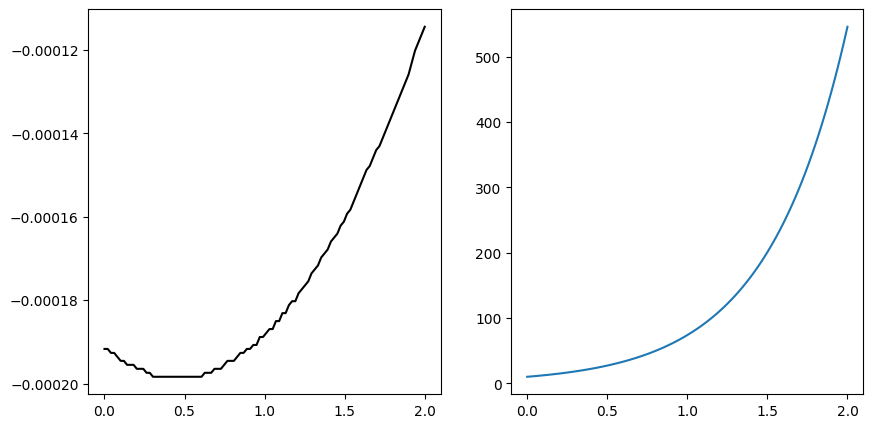

In [110]:
y = learner.model.forward(train.x.view(100, 1))
y = y.detach().cpu()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)

ax.plot(train.x, 10 + y.flatten(), color="black")

ax1 = fig.add_subplot(122)
ax1.plot(train.x, train.y)